<a href="https://colab.research.google.com/github/pradeepkmaran/fake-news-detector-OneHot/blob/main/FakeNewsDetector_OneHot_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Science - Assignment 2**


**Team Members:**


1.   Oviasree S- 3122 22 5001 088
2.   Pradeep KM- 3122 22 5001 092
3.   Rithekha K- 3122 22 5001 106




# **Fake News Detection using OneHot and LSTM**

# **Importing modules and opening files:**

In [ ]:
#Importing the necessary modules

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import to_categorical

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# **Dataset for Modeling:**

**True.csv and Fake.csv**   [Source: kaggle.com]


The True.csv contains news that are verified to be true values and the Fake.csv contains news that have been circulated wrongly. Both these files contain four columns namely title, text, subject and date.


There are around 20000 records each in the True news file and the Fake news file. We have around 40000 news records in total.


The news collected spans across all the months from years 2015 to 2017 and is mainly focussed on the American Geography.


In [ ]:
#Mounting drive and datasets to colab

from google.colab import drive
drive.mount('/content/drive')

trueDataSet = '/content/drive/MyDrive/FakeNews/True.csv'
fakeDataSet = '/content/drive/MyDrive/FakeNews/Fake.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Creating dataframes- true and false data

true = pd.read_csv(trueDataSet, encoding='utf-8')
fake = pd.read_csv(fakeDataSet, encoding='utf-8')

#Printing the first few records of the true and false news available

print('First 10 true news records: ')
print(true.head())
print()
print('First 10 false news records: ')
print(fake.head())
print()

First 10 true news records: 
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   

First 10 false news records: 
                                      

In [ ]:
#Adding a category column to differentiate the credibility of the news records

true['category'] = 1
fake['category'] = 0

#Creating a joint dataframe
news = pd.concat([true, fake])
news.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# **Exploratory Data Analysis:**

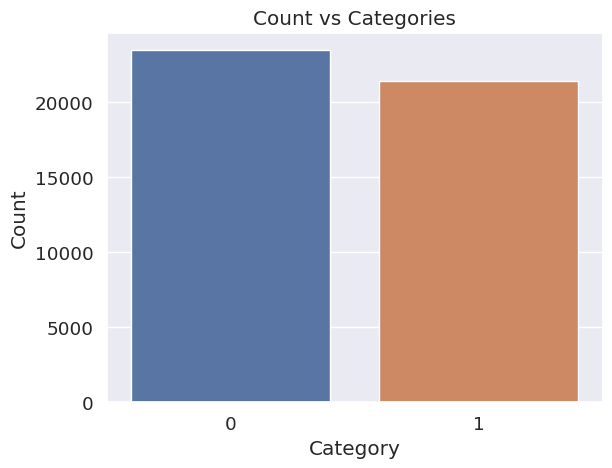

In [ ]:
#Analysing and Preprocessing the Data

#Plotting the data using seaborn module

sns.set_style('darkgrid')

sns.countplot(data=news, x='category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count vs Categories')
plt.show()



In [ ]:
#Data Cleansing

#Checking for missing or NAN values
print('Missing value statistics:')
print(news.isna().sum())
print()
print('Null value statistics:')
print(news.isnull().sum())

Missing value statistics:
title       0
text        0
subject     0
date        0
category    0
dtype: int64

Null value statistics:
title       0
text        0
subject     0
date        0
category    0
dtype: int64


In [ ]:
#Total data available
news.title.count()

#Types of news available
news.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

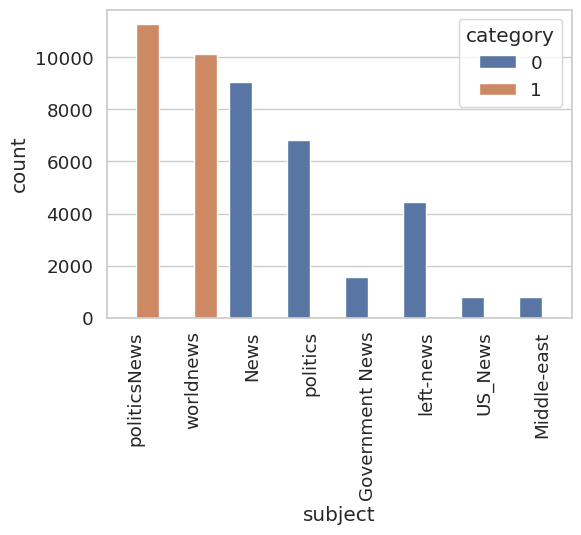

In [ ]:
#Plotting subject wise

plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = news)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

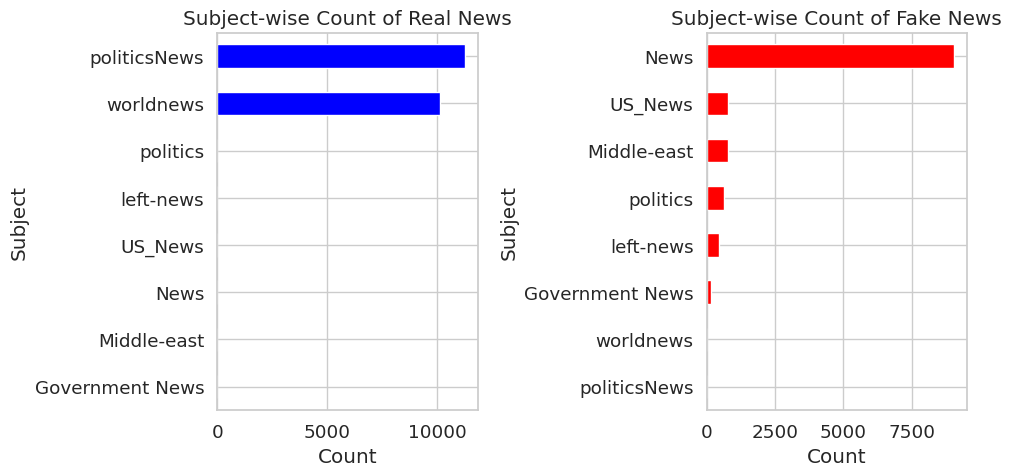

In [ ]:
# subject wise most fake and real news

# Group by subject and category, and calculate count
subject_count = news.groupby(['subject', 'category']).size().unstack().fillna(0)

# Plotting
plt.figure(figsize=(10, 5))

# Real News
plt.subplot(1, 2, 1)
subject_count[1].sort_values().plot(kind='barh', color='blue')
plt.title('Subject-wise Count of Real News')
plt.xlabel('Count')
plt.ylabel('Subject')

# Fake News
plt.subplot(1, 2, 2)
subject_count[0].sort_values().plot(kind='barh', color='red')
plt.title('Subject-wise Count of Fake News')
plt.xlabel('Count')
plt.ylabel('Subject')

plt.tight_layout()
plt.show()

The above two bar graphs show the different subjects that in covered in real and fake news. In the true news, we have only 2 subjects( politicalnews and worldnews) whereas in in fake news, we have 6 subjects( News, Government News, left-news, US_News and Middle-east)


<ipython-input-51-00dfd10c383a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news['year'] = news['date'].dt.year


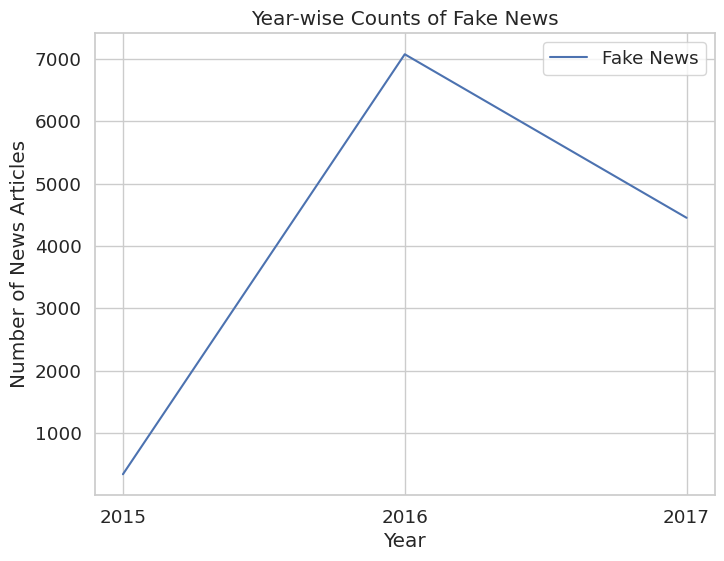

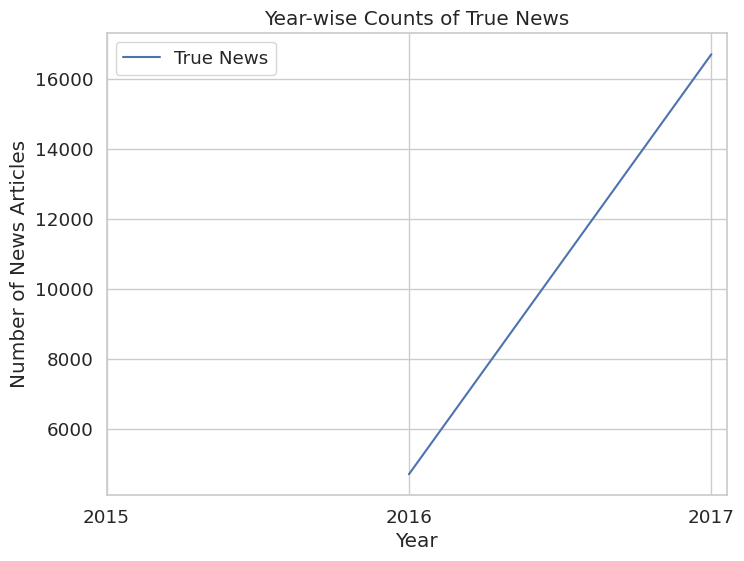

In [ ]:
# Combine the dataframes into a single dataframe
news = pd.concat([true, fake])

# Strip leading and trailing whitespace from the date column
news['date'] = news['date'].str.strip()

# Convert date column to datetime format
news['date'] = pd.to_datetime(news['date'], errors='coerce', format='%B %d, %Y')

# Remove rows with invalid dates
news = news.dropna(subset=['date'])

# Extract year column
news['year'] = news['date'].dt.year

# Group by year and category and calculate counts
year_wise_counts = news.groupby(['year', 'category']).size().unstack()

# Filter the data for the years 2015 to 2017
year_wise_counts = year_wise_counts.loc[2015:2017]

# Plot the year-wise counts of fake news
fake_counts = year_wise_counts[0]
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
plt.plot(fake_counts.index, fake_counts.values, label='Fake News')
plt.xlabel('Year')
plt.ylabel('Number of News Articles')
plt.title('Year-wise Counts of Fake News')
plt.legend()
plt.xticks(year_wise_counts.index)  # Set the x-axis ticks to the available years
plt.show()

# Plot the year-wise counts of true news
true_counts = year_wise_counts[1]
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
plt.plot(true_counts.index, true_counts.values, label='True News')
plt.xlabel('Year')
plt.ylabel('Number of News Articles')
plt.title('Year-wise Counts of True News')
plt.legend()
plt.xticks(year_wise_counts.index)  # Set the x-axis ticks to the available years
plt.show()


In the above graphs, the first line graph shows the year-wise count of fake news. From this, we infer that fake news were minimal in the year 2015 and maximum in the year 2016. The second line graph shows the year-wise count of true news. From this, we infer that there was no fake news in the year 2015 and maximum in the year 2017.


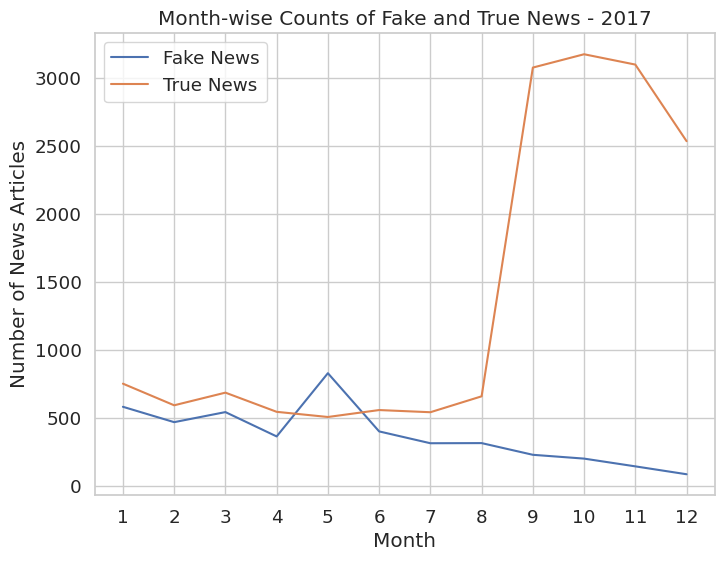

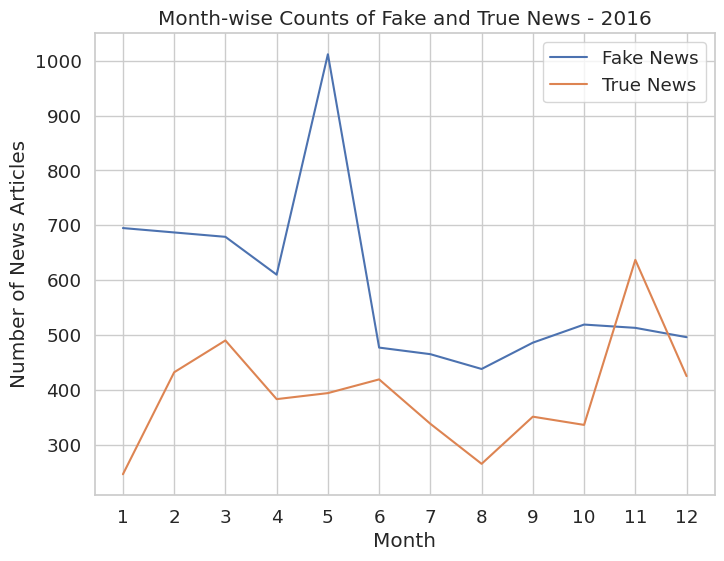

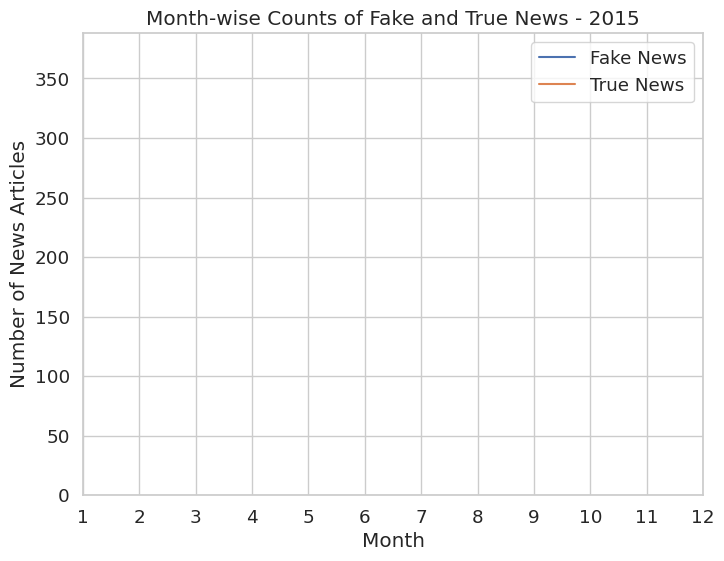

In [ ]:
#month-wise count of real and fake news in each year

# Combine the dataframes into a single dataframe
news = pd.concat([true, fake])

# Strip leading and trailing whitespace from the date column
news['date'] = news['date'].str.strip()

# Convert date column to datetime format
news['date'] = pd.to_datetime(news['date'], errors='coerce', format='%B %d, %Y')

# Remove rows with invalid dates
news = news.dropna(subset=['date'])

# Extract year and month columns
news['year'] = news['date'].dt.year
news['month'] = news['date'].dt.month

# Group by year, month, and category and calculate counts
month_wise_counts = news.groupby(['year', 'month', 'category']).size().unstack()

# Filter the data for the years 2015 to 2017
month_wise_counts = month_wise_counts.loc[2015:2017]

# Get unique years
years = news['year'].unique()

# Create separate line graphs for each year
for year in years:
    plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference

    # Filter data for the specific year
    year_data = month_wise_counts.loc[year]

    # Plot the month-wise counts of fake news
    fake_counts = year_data[0]
    plt.plot(fake_counts.index, fake_counts.values, label='Fake News')

    # Plot the month-wise counts of true news
    true_counts = year_data[1]
    plt.plot(true_counts.index, true_counts.values, label='True News')

    # Set labels and title
    plt.xlabel('Month')
    plt.ylabel('Number of News Articles')
    plt.title(f'Month-wise Counts of Fake and True News - {year}')
    plt.legend()
    plt.xticks(range(1, 13))  # Set the x-axis ticks to cover all months

    # Adjust y-axis scale for 2015 to emphasize fake news
    if year == 2015:
        plt.ylim(0, max(fake_counts.max(), true_counts.max()) + 50)

    # Show the plot
    plt.show()

In the above line graphs, the first graph shows the month-wise count of real and fake news in the year 2017. The no. of fake news in 2017 is less than the no. of true news. Also no. of true news peaked to a value of 3300(approx) in the month of october.

The second line graph shows the month-wise count of real and fake news in the year 2016. The no. of real news in 2016 is less than the no. of true news. Also no. of fake news peaked to a value of 1000(approx) in the month of may and the no. of true news peaked in the month of november .


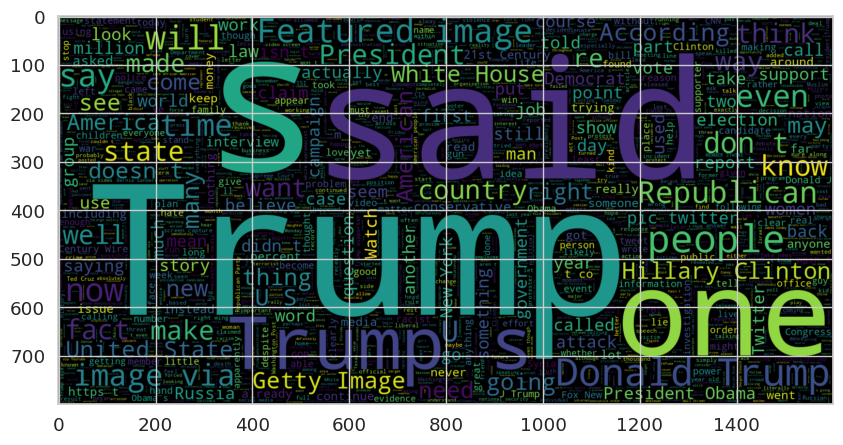

In [ ]:
plt.figure(figsize = (10,10)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

The above is a word cloud representing the count of words in fake news. From this, we can infer that said, Donald Trump and one are the top 3 used words in fake news.


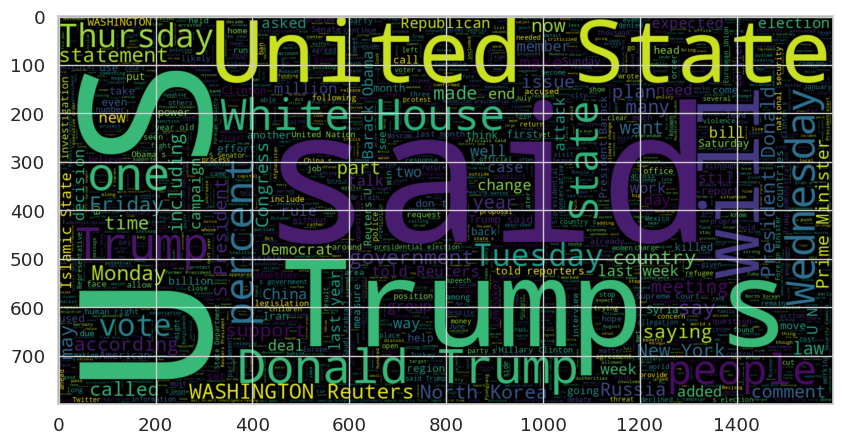

In [ ]:
plt.figure(figsize = (10,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

The above is a word cloud representing the count of words in true news. From this, we can infer that US, said and Trump are the top 3 used words in true news.


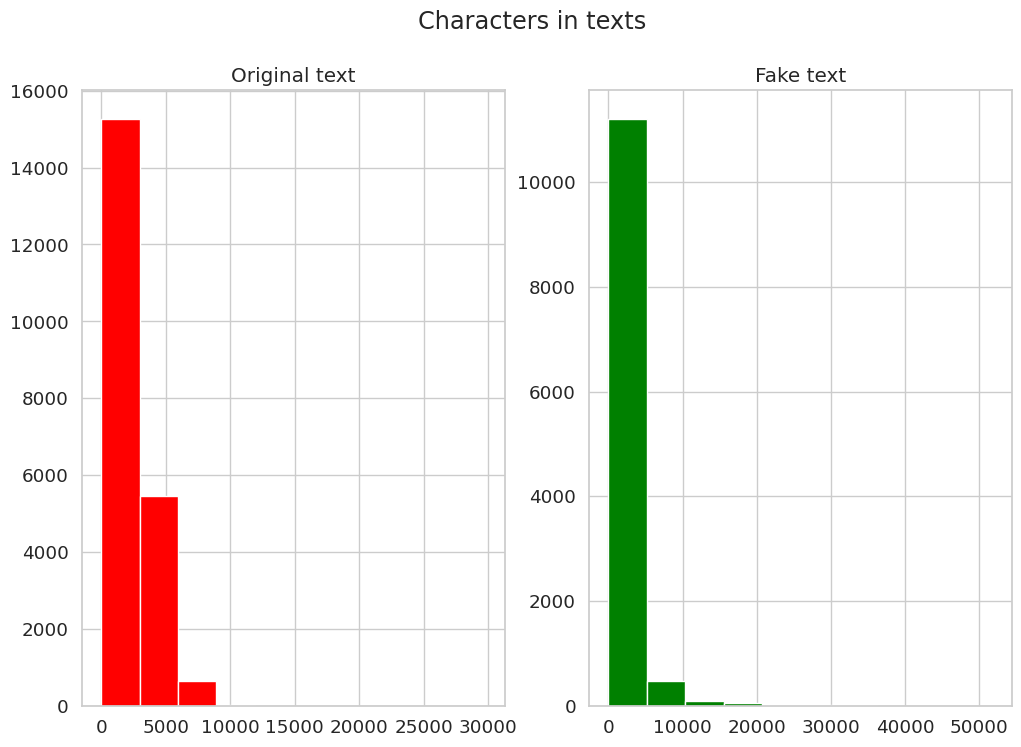

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=news[news['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=news[news['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

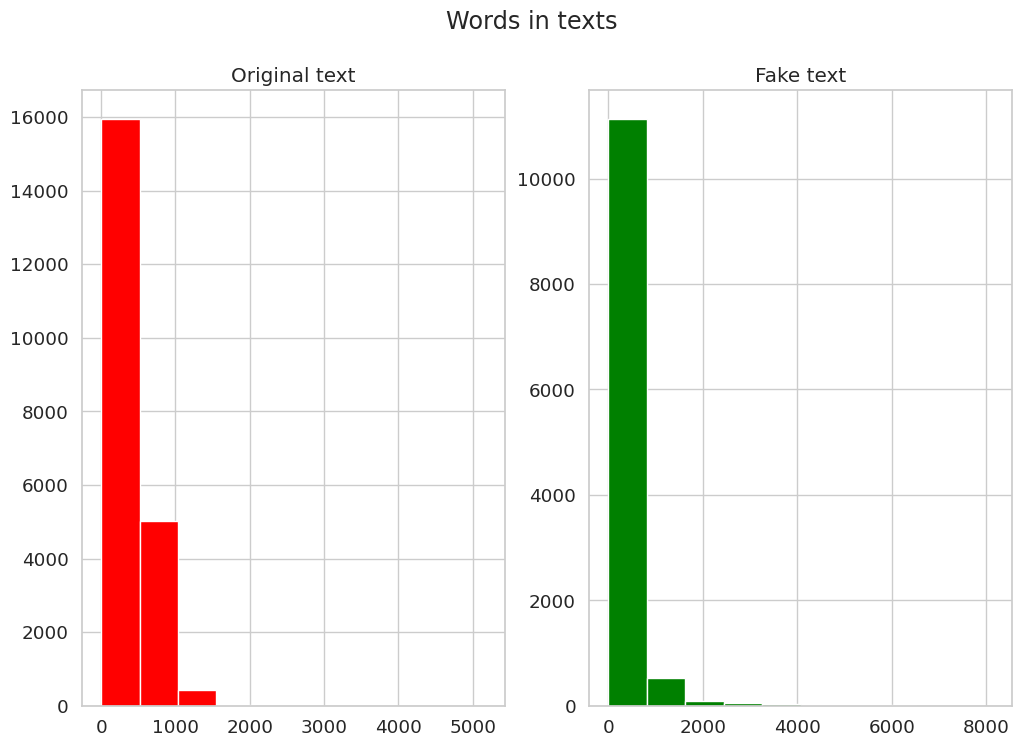

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=news[news['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=news[news['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-59-ad5175fd550a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-

Text(0.5, 0.98, 'Average word length in each text')

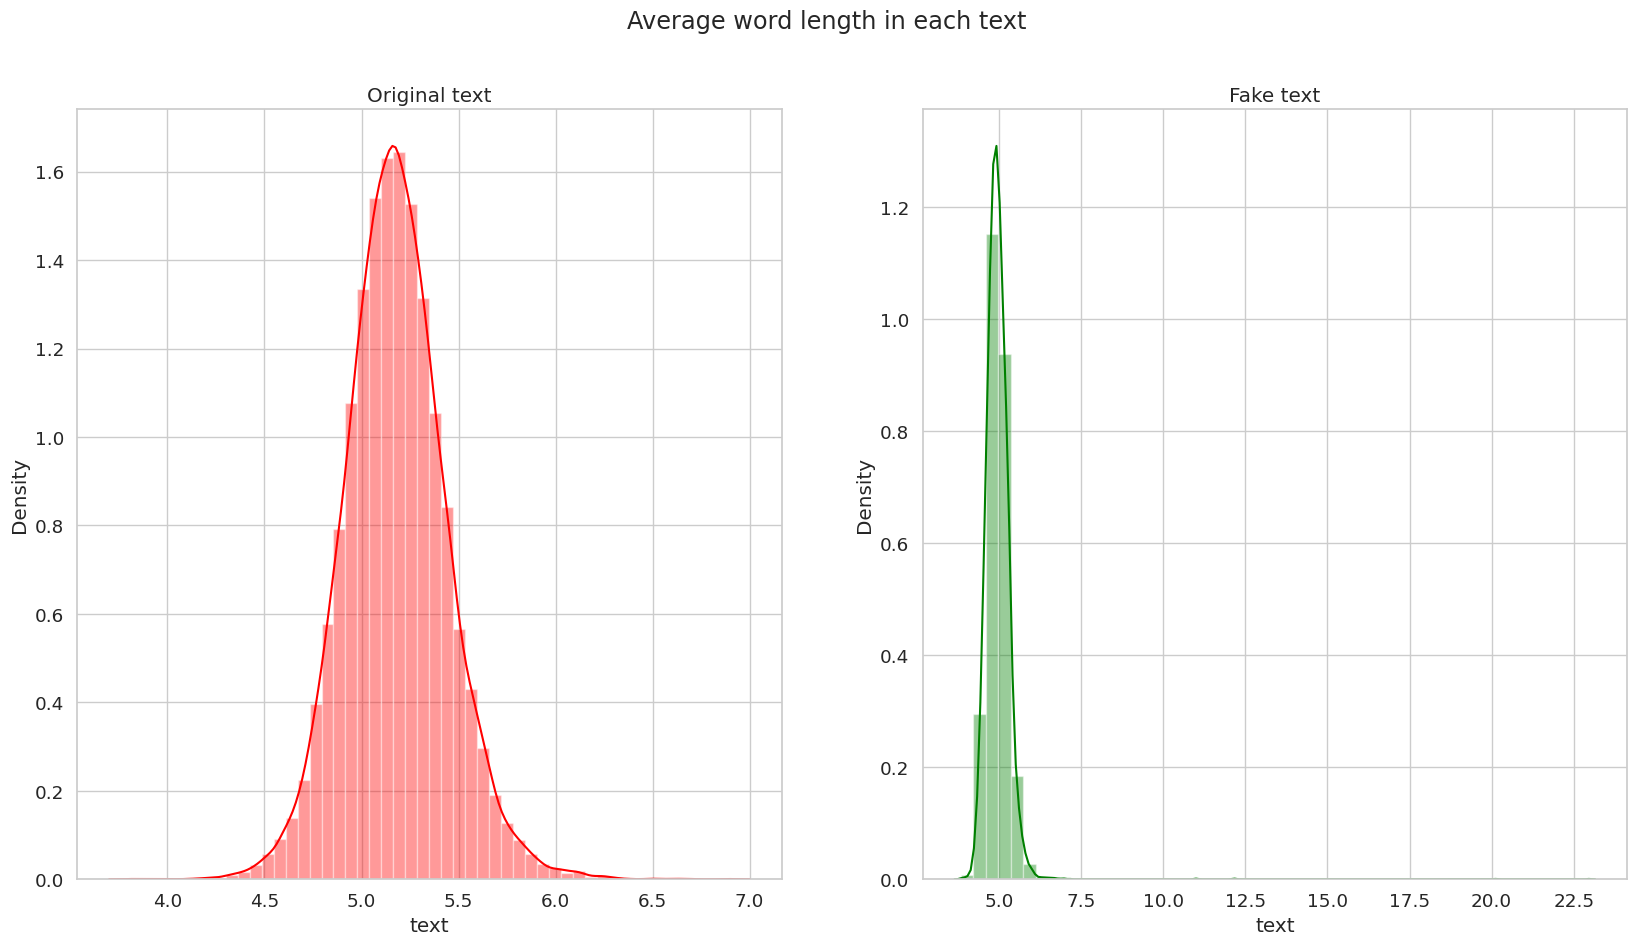

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=news[news['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=news[news['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

<Axes: >

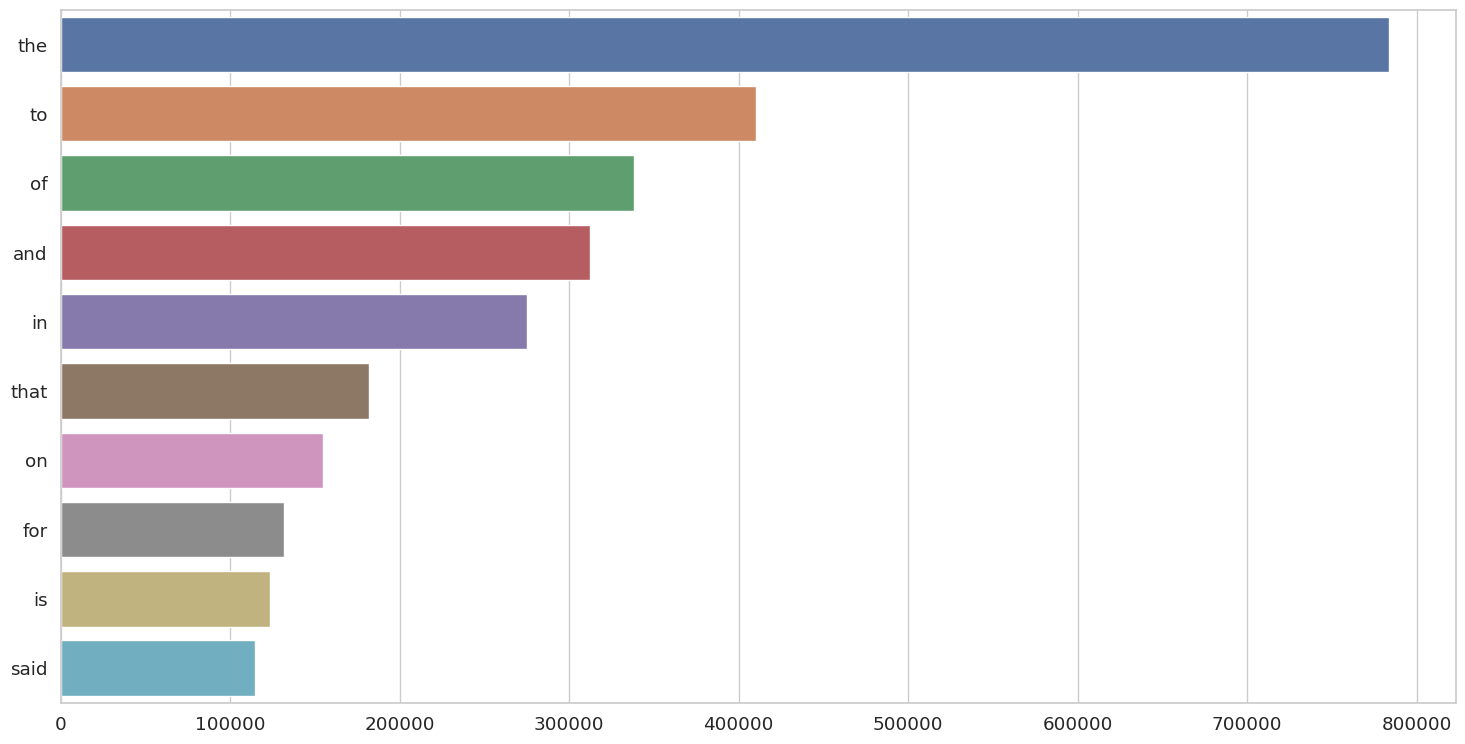

In [ ]:
plt.figure(figsize = (18,9))
most_common_uni = get_top_text_ngrams(news.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

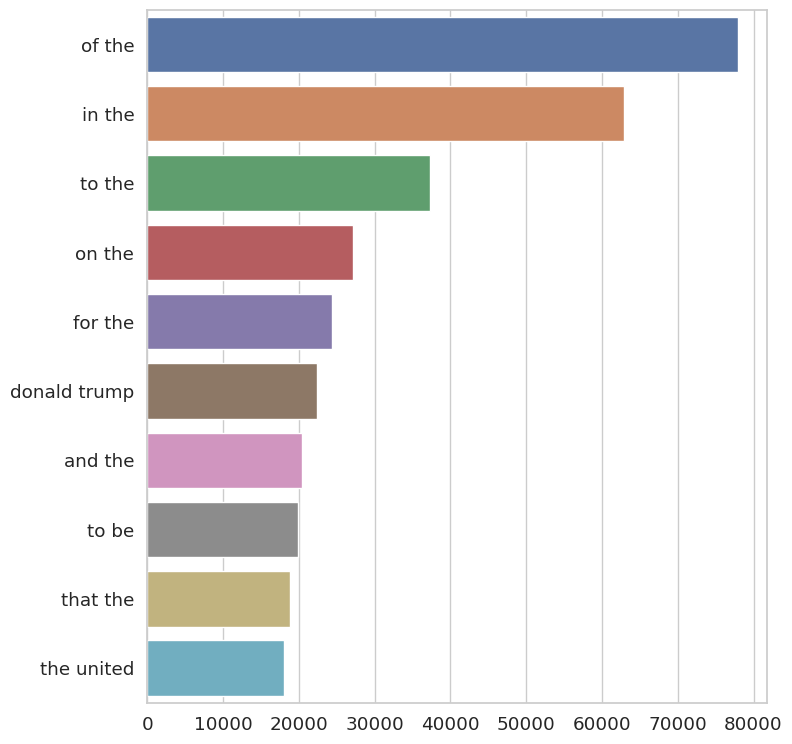

In [ ]:
plt.figure(figsize = (8,9))
most_common_bi = get_top_text_ngrams(news.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

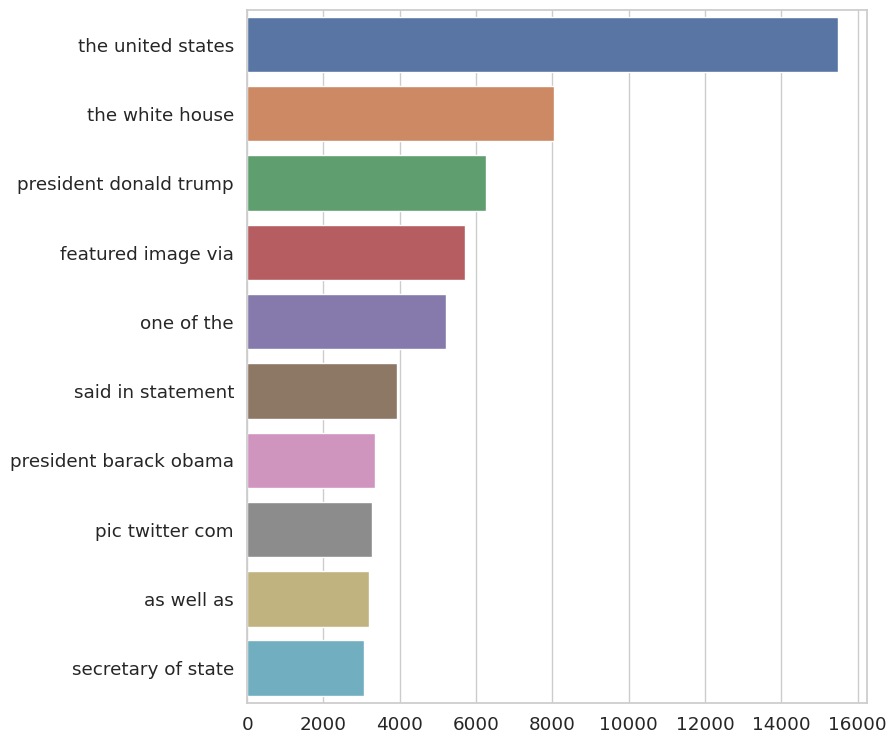

In [ ]:
plt.figure(figsize = (8,9))
most_common_tri = get_top_text_ngrams(news.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

# **Data Preparation:**

In [ ]:
#Adding text and title columns

news['text'] = news['text'] + " " + news['title']
del news['title']
del news['subject']
del news['date']

news.head()

,text,category,year,month
0,WASHINGTON (Reuters) - The head of a conservat...,1,2017,12
1,WASHINGTON (Reuters) - Transgender people will...,1,2017,12
2,WASHINGTON (Reuters) - The special counsel inv...,1,2017,12
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1,2017,12
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,2017,12


In [ ]:
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
print(stop)

{'am', 'nor', 'both', '$', 'mustn', 'its', 'who', "wasn't", '-', '_', 'itself', 'at', 'from', 'doesn', 's', ')', ';', 'will', 'm', ',', 'his', 'can', 'same', 'me', "couldn't", 'hadn', 'weren', 'yourself', 'has', 'hers', "you've", 'myself', 'while', 'our', 'had', 'how', 'which', 'during', 'my', 'when', 'don', '\\', 'between', 'own', 'ours', '.', 'so', 'doing', '"', 'a', "shan't", "weren't", 'wouldn', 'couldn', 'we', '+', 'i', 'only', 've', 'with', 'where', 'wasn', '%', "should've", 'himself', 'it', 'should', 'again', 'whom', '}', 'the', 'won', 'in', "hasn't", 'yours', 'down', 'if', "haven't", 'theirs', '(', 'he', "don't", '*', 'until', 'about', 'yourselves', 'to', 'into', 'themselves', '[', '<', ':', 'above', 'their', '`', 'by', '|', "she's", 'this', "hadn't", 'no', 'there', 'some', "needn't", 'were', 'under', 'you', "didn't", 'other', 'but', "you're", '#', "it's", 'most', 't', "you'll", "aren't", 'be', '&', '!', 'she', 'just', 'of', '=', 'is', 'll', '^', 'all', 'over', 'they', 'up', 't

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
news['text']=news['text'].apply(denoise_text)
news['text'].head()

<ipython-input-65-6b5fa97bc6a7>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


0    WASHINGTON (Reuters) head conservative Republi...
1    WASHINGTON (Reuters) Transgender people allowe...
2    WASHINGTON (Reuters) special counsel investiga...
3    WASHINGTON (Reuters) Trump campaign adviser Ge...
4    SEATTLE/WASHINGTON (Reuters) President Donald ...
Name: text, dtype: object

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(news.text)
corpus[:9]

['WASHINGTON',
 '(Reuters)',
 'head',
 'conservative',
 'Republican',
 'faction',
 'U.S.',
 'Congress,',
 'voted']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(20)
most_common = dict(most_common)
most_common

{'Trump': 93864,
 'said': 81713,
 'U.S.': 45705,
 'would': 45450,
 'President': 25282,
 'people': 24875,
 'also': 24375,
 'said.': 23503,
 'Donald': 23462,
 'one': 21823,
 'Republican': 21319,
 '(Reuters)': 21240,
 'could': 19657,
 'House': 19482,
 'United': 19342,
 'government': 18767,
 'told': 18418,
 'last': 15327,
 'like': 14680,
 'two': 14343}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# **More about the problem, and Embedding:**

Our problem is a classification problem, where we need to classify the input into two types- true or false. Also it’ll be requiring a supervised machine learning approach since we have the labels- 0 or 1 to be predicted.


We’ll first be working on the text data available. We’ll be removing extra spaces, splitting the text into words and removing repetitive/ unnecessary words [stop words]. We’ll be processing all the useful words available in the entire dataset using the OneHot Representation and assign each word an unique id from the vocabulary. These OneHot ids are then embedded into vectors which aid in training the model.


In [ ]:
#Finding out one hot representations of words in the news

voc_size = 10000
onehot_repr = [one_hot(words, voc_size) for words in news['text']]

In [ ]:
print(onehot_repr[0:12])

[[3138, 3193, 6403, 3479, 9739, 5797, 1320, 7961, 3923, 4239, 1087, 2910, 8527, 1248, 3193, 2877, 4935, 4268, 9289, 7192, 3803, 8236, 7013, 4998, 4122, 3788, 7159, 7768, 897, 8398, 432, 8638, 1320, 7961, 2464, 1637, 8491, 6991, 7757, 5163, 3361, 700, 5887, 4365, 8630, 419, 6830, 880, 1582, 5142, 6616, 1491, 8199, 3410, 880, 2950, 1790, 7857, 419, 4998, 289, 2573, 2647, 8297, 1380, 4316, 8272, 8188, 6512, 5398, 8017, 5997, 8638, 4814, 2388, 6330, 3923, 2530, 1755, 19, 8638, 5657, 1014, 4998, 7820, 8472, 6830, 8330, 6869, 5657, 4071, 7623, 4864, 4086, 1065, 6830, 61, 1765, 3689, 818, 5113, 6536, 6900, 1774, 5481, 3799, 1901, 19, 8365, 4708, 6594, 1767, 9367, 3447, 7820, 4864, 4086, 3849, 6830, 2836, 4222, 5789, 8491, 6619, 7923, 3792, 3137, 8286, 6008, 4755, 7148, 1385, 8330, 2286, 9414, 4543, 8170, 375, 207, 2877, 2159, 955, 8977, 4222, 6298, 3479, 4772, 3451, 2048, 5998, 4511, 6565, 6952, 6841, 700, 4755, 8491, 432, 8638, 4239, 1497, 7178, 1130, 3193, 4608, 4935, 1754, 1452, 1152, 419,

In [ ]:
#Padding to make have embedded records of same shape

length = 250
embedded_docs = sequence.pad_sequences(onehot_repr, padding = 'pre', maxlen=length)


In [ ]:
print(embedded_docs[0])

[ 700 5379 4755 8638 2253 4935 1756 4247 1320 7961 4935 1754 2677 5511
 8211 1048 5472 1748 3137 3794 8848 7921 6869 6794 4935 7346 1660  356
 8491 7135 8008 5086 3273 7103 9773 2946  700 7598 1194  751 2359 8945
 1189 9739 2050 3788 9739  213 1045   61 8623 8131 4354  372 3942 4787
 1023 1774  339  990 7920  650 8439   61 3054 3138 1201  349 8330 8445
 5615 7240 7178 5894 2286 3926 8638 8945 5599 2877 4935 1754 1319 6830
 4268 8109   61 4152 3137 8638 1360 8189 8273 7251 8155 7944 8330 9369
 7778 4998 3086  207 8642 8330 5341 3206 8155 8638 2232 6330 1090 3849
 4864 4086   61 8109 6830 4167   52 5477  700 9990 1597 7853 9743 1678
   19  335 7830 5084 3788 4273  382 7710 5668 9331 1003 2297 7148 8501
 6307 1863  660 4780 8089 4752 2530 4755 3938 9981 5382 5269 2500 6241
 1597 4195 6309 1380   68 2372 4640 5795 4238 1767 2464 3664 4486 5473
 3928  312  554   52 4316 7217 6309 2500 7993 8170 2297 2671  700 4755
 3410   19 6058 4348 6512 4329 8094 8297 9920 6580 6216    1   19 9739
 4329 

In [ ]:
xFinal = embedded_docs
yFinal = news.category

print(xFinal.shape)
print(yFinal.shape)

(33285, 250)
(33285,)


# **Various Possible Approaches:**

We have the embedded vectors of all the words prepared, and have the training data ready which will constitute about 70 percent of total data. We can fit these into a number of different supervised, classification machine learning approaches such as logistic regression, decision tree, random forest and deep learning.


# **Our Machine Learning Approach:**

We have used 2 different Machine Learning Algorithms to classify a given news into Fake news or Real news.

1. **LSTM - Long Short Term Memory**

  LSTM is a type of neural network that's great at understanding and predicting sequences of data, like sentences or time-based patterns. It's especially useful in tasks like language processing, speech recognition, and analyzing time series data. Unlike other networks, LSTMs have a memory that can remember important information over long sequences, making them good at capturing complex relationships and handling inputs of different lengths.

  Why choose LSTM?


*   Can handle variable-length input sequences.
*   Well-suited for sequential data and tasks with temporal dependencies.
*Effective for tasks like sentiment analysis, machine translation, speech recognition, and time series prediction.



2. **Logistic Regression**

  Logistic Regression is a linear classification algorithm used for binary classification problems. It is a simple yet effective algorithm that models the relationship between the independent variables (features) and the binary outcome (target variable).

  Why choose Logistic Regression?


*   Works well for binary classification tasks.
*   Assumes a linear relationship between features and the log-odds of the outcome.
* Can handle both continuous and categorical input features.


This code demonstrates the use of LSTM Machine Learning Model combined with one hot embedding.





In [ ]:
x_train,x_test,y_train,y_test = train_test_split(xFinal, yFinal, random_state=0, test_size=0.33)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(10000, 100, input_length=250))
#LSTM
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          1000000   
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None


# **Model Fitting:**

In [ ]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 3,  batch_size=64)

Epoch 1/3
349/349 [==============================] - 206s 579ms/step - loss: 0.0811 - accuracy: 0.9674 - val_loss: 0.0195 - val_accuracy: 0.9944
Epoch 2/3
349/349 [==============================] - 216s 620ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0251 - val_accuracy: 0.9922
Epoch 3/3
349/349 [==============================] - 216s 619ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0248 - val_accuracy: 0.9943


# **Evaluation of Model Performance:**

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

697/697 [==============================] - 76s 109ms/step - loss: 4.9268e-04 - accuracy: 1.0000
Accuracy of the model on Training Data is -  99.99551773071289 %
344/344 [==============================] - 24s 70ms/step - loss: 0.0248 - accuracy: 0.9943
Accuracy of the model on Testing Data is -  99.42649006843567 %


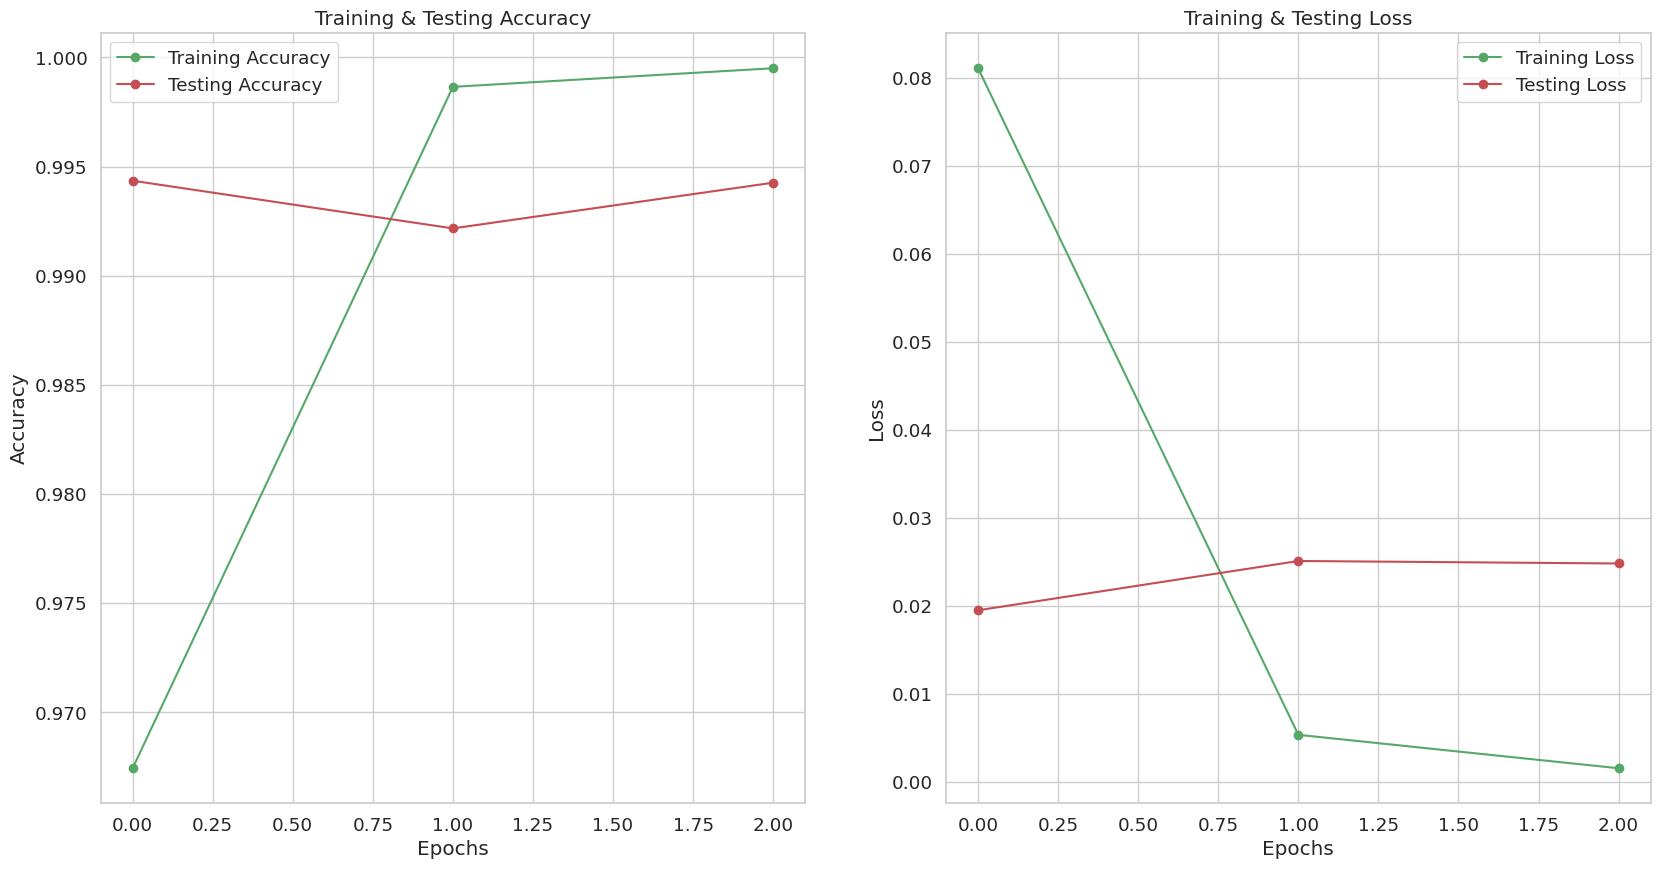

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = (model.predict(x_test) > 0.5).astype("int32")
pred[:5]

344/344 [==============================] - 25s 70ms/step


array([[1],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      3990
    Not Fake       0.99      1.00      1.00      6995

    accuracy                           0.99     10985
   macro avg       0.99      0.99      0.99     10985
weighted avg       0.99      0.99      0.99     10985



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[3942,   48],
       [  15, 6980]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(25.75, 0.5, 'Actual')

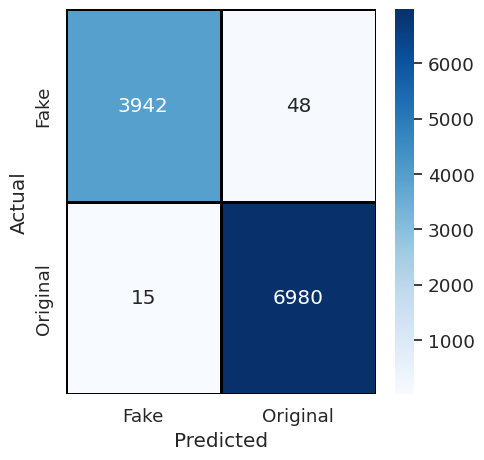

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# **Conclusions:**

Our model helps in classifying a given piece of news as fake or true, based on the embedded word knowledge and the huge number of both kinds of data that it has been trained with.

We have limited our epochs number to 3 to prevent overfitting and loss of data during training. And we have chosen our batch size as 64.

Using the LSTM Machine Learning approach we have achieved an accuracy percentage of

The confusion matrix gives us a summary of how well the fake and true news have been recognized and mapped to their labels. There are very few- 15 and 48 records that have been misclassified by the model. Also we can observe that the number of fake news that has been classified as true (48) is higher than the number of true news that have been disregarded as fake(15). Looking on the brighter side of our model, it has managed to classify 3942 and 6980 news records as fake and true news correctly.




